In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Mar 27 16:36:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8              4W /   30W |       6MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [4]:
!pip install playground

In [5]:
#@title Import The Playground
import importlib
from mujoco_playground import wrapper
from mujoco_playground import registry
importlib.reload(wrapper)
importlib.reload(registry)

<module 'mujoco_playground._src.registry' from '/home/ps/Documents/mujoco_playground/mujoco_playground/_src/registry.py'>

In [6]:
registry.locomotion.ALL_ENVS

('BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain',
 'BaiJoystickFlatTerrain')

In [7]:
env_name = 'BaiJoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [8]:
env_cfg

Kd: 0.5
Kp: 15.0
action_repeat: 1
action_scale: 0.5
command_config:
  a:
  - 1.5
  - 0.8
  - 1.2
  b:
  - 0.9
  - 0.25
  - 0.5
ctrl_dt: 0.02
episode_length: 1000
history_len: 1
noise_config:
  level: 1.0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.03
    joint_vel: 1.5
    linvel: 0.1
pert_config:
  enable: false
  kick_durations:
  - 0.05
  - 0.2
  kick_wait_times:
  - 1.0
  - 3.0
  velocity_kick:
  - 0.0
  - 0.5
reward_config:
  max_foot_height: 0.05
  scales:
    action_rate: -0.01
    ang_vel_xy: -0.05
    dof_pos_limits: -1.0
    energy: -0.001
    feet_air_time: 0.1
    feet_clearance: -2.0
    feet_height: -0.2
    feet_slip: -0.1
    lin_vel_z: -0.5
    orientation: -5.0
    pose: 0.5
    stand_still: -1.0
    termination: -1.0
    torques: -0.0002
    tracking_ang_vel: 0.5
    tracking_lin_vel: 1.0
  tracking_sigma: 0.25
sim_dt: 0.004
soft_joint_pos_limit_factor: 0.95

In [10]:
import importlib
from mujoco_playground.config import locomotion_params
# Reload the module
importlib.reload(locomotion_params)
# Use the config
ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 1024
num_evals: 5
num_minibatches: 32
num_timesteps: 100000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20

Let's train with ppo

In [11]:
registry.get_domain_randomizer(env_name)

Env 'BaiJoystickFlatTerrain' does not have a domain randomizer in the locomotion registry.


In [13]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
print(ppo_training_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

Env 'BaiJoystickFlatTerrain' does not have a domain randomizer in the locomotion registry.
{'action_repeat': 1, 'batch_size': 256, 'discounting': 0.97, 'entropy_cost': 0.01, 'episode_length': 1000, 'learning_rate': 0.0003, 'max_grad_norm': 1.0, 'network_factory': policy_hidden_layer_sizes: &id001 !!python/tuple
- 512
- 256
- 128
policy_obs_key: state
value_hidden_layer_sizes: *id001
value_obs_key: privileged_state
, 'normalize_observations': True, 'num_envs': 1024, 'num_evals': 5, 'num_minibatches': 32, 'num_timesteps': 100000000, 'num_updates_per_batch': 4, 'reward_scaling': 1.0, 'unroll_length': 20}


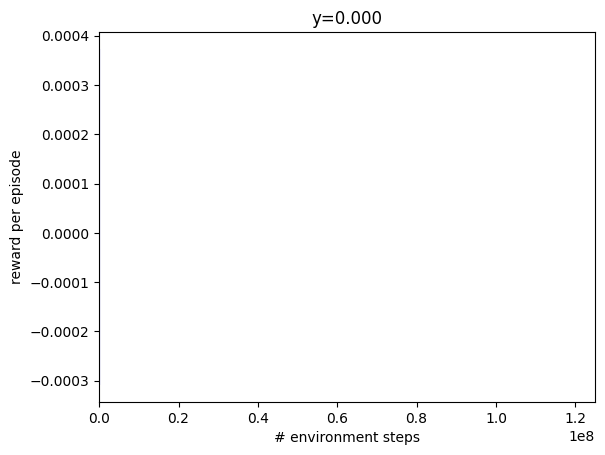

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [50]:
print("env obs shape:", env.observation_size)
print("eval_env obs shape:", registry.load(env_name, config=env_cfg).observation_size)

env obs shape: {'privileged_state': (81,), 'state': (30,)}
eval_env obs shape: {'privileged_state': (81,), 'state': (30,)}


In [51]:
print("env action size:", env.action_size)
print("eval_env action size:", registry.load(env_name, config=env_cfg).action_size)

env action size: 6
eval_env action size: 6
